In [1]:
library(readr)
library(limma)
library(tximport)
library(edgeR)
library(ggplot2)
library(psych)
sessionInfo()


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/taejoon/miniconda3/envs/r4-base/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=ko_KR.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ko_KR.UTF-8        LC_COLLATE=ko_KR.UTF-8    
 [5] LC_MONETARY=ko_KR.UTF-8    LC_MESSAGES=ko_KR.UTF-8   
 [7] LC_PAPER=ko_KR.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ko_KR.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] psych_2.1.9     ggplot2_3.3.5   edgeR_3.32.1    tximport_1.18.0
[5] limma_3.46.0    readr_2.1.1    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7       pillar_1.6.4     compiler_4.0.5   base64enc_0.1-3 
 [5] tools_4.0.5      digest_0.6.29    uuid_1.0-3       nlme_3.1-153    
 [9] jso

In [8]:
# Prepare tx2gene
filename_tx2gene <- 'XENTR_xenTro9_tx.XB202104.tx2gene'
#filename_tx2gene <- 'XENLA_XB201901_tx.HUMAN_ens95.tx2gene'
tx2gene <- read_tsv(filename_tx2gene, col_names=FALSE)
colnames(tx2gene) <- c('txName', 'geneName')
head(tx2gene)

Rows: 34192 Columns: 2

── Column specification ──────────────────────────────────────────────────
Delimiter: "\t"
chr (2): X1, X2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



txName,geneName
<chr>,<chr>
1520401a03rik|rna38683|gene18120|Level=3,1520401a03rik
1700017n19rik|rna13547|gene4145|Level=3,1700017n19rik
1700024j04rik|rna63696|gene33803|Level=3,1700024j04rik
2310030g06rik|rna37370|gene17316|Level=3,2310030g06rik
42Sp43|rna6187|gene1894|Level=1,42Sp43
42Sp50|rna26867|gene8315|Level=1,42Sp50


In [25]:
# Load quantification data
#library(edgeR)

# Uncomment and change the filename below
filename_tbl <- 'PRJEB36722_XENTRtx_Pelzer2021.conf'
file.exists(filename_tbl)

samples <- read.table(filename_tbl, header=TRUE)
files <- trimws(samples$Filename)
names(files) <- trimws(samples$SampleName)
all(file.exists(files))

txi <- tximport(files, type = "kallisto", tx2gene = tx2gene, countsFromAbundance = "lengthScaledTPM")
head(txi$counts)

[1] TRUE

[1] TRUE

Note: importing `abundance.h5` is typically faster than `abundance.tsv`

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 


transcripts missing from tx2gene: 1

summarizing abundance

summarizing counts

summarizing length



,dpa0_1,dpa0_2,dpa0_3,dpa1_1,dpa1_2,dpa1_3,dpa3_1,dpa3_2,dpa3_3
1520401a03rik,3.000263,16.9958828,0.000000,1.000106,0.000000,1.000070,0.0000000,1.999110,0.9995424
1700017n19rik,2.000173,8.9978176,3.996701,5.000543,2.000189,8.000551,9.9774213,8.996012,7.9963221
1700024j04rik,0.000000,0.9997589,0.000000,1.000109,0.000000,0.000000,0.0000000,0.000000,0.0000000
2310030g06rik,212.018416,226.9449107,321.734259,149.015888,182.017126,191.013279,297.3269672,373.833941,265.8778241
42Sp43,0.000000,0.0000000,0.000000,3.000323,1.000093,3.000205,0.9977432,1.999113,0.9995428
42Sp50,14.001217,28.9929411,6.994233,17.001807,13.001241,9.000631,9.9774241,15.992884,16.9922031


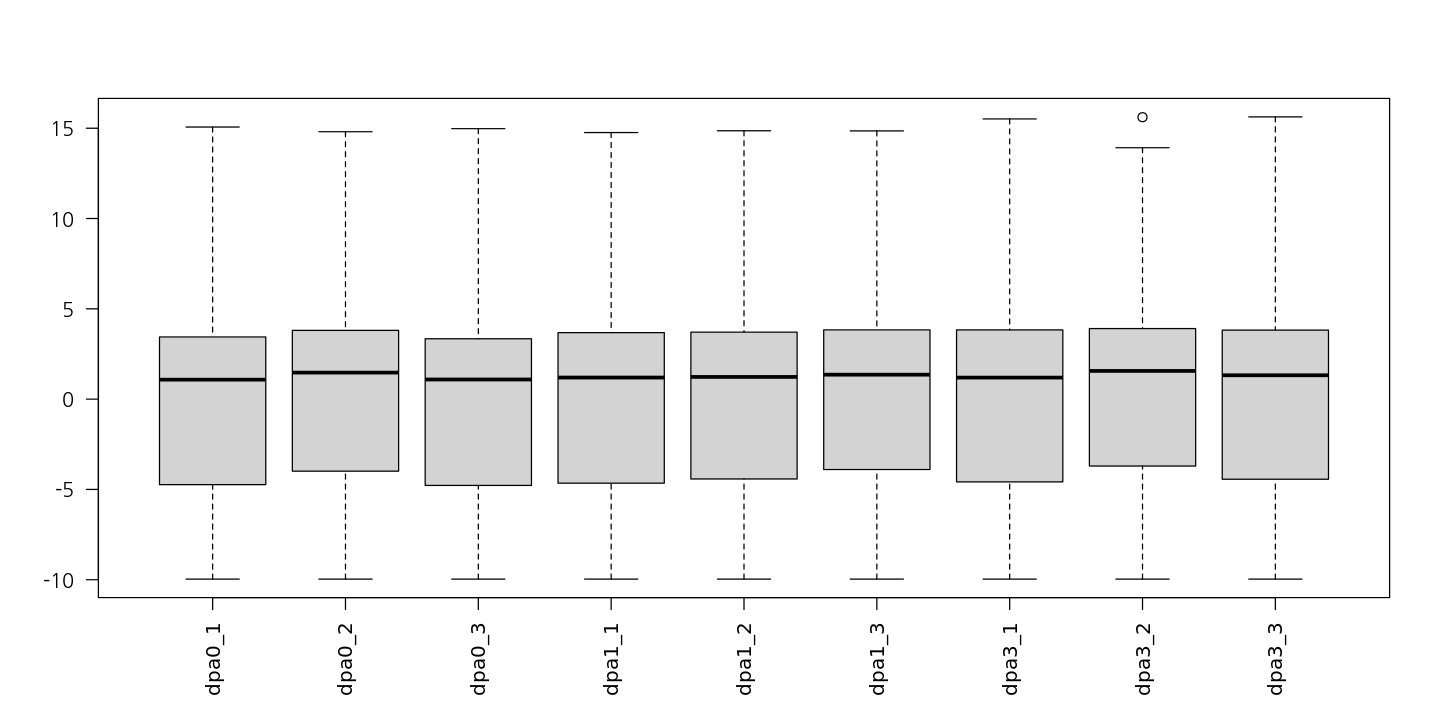

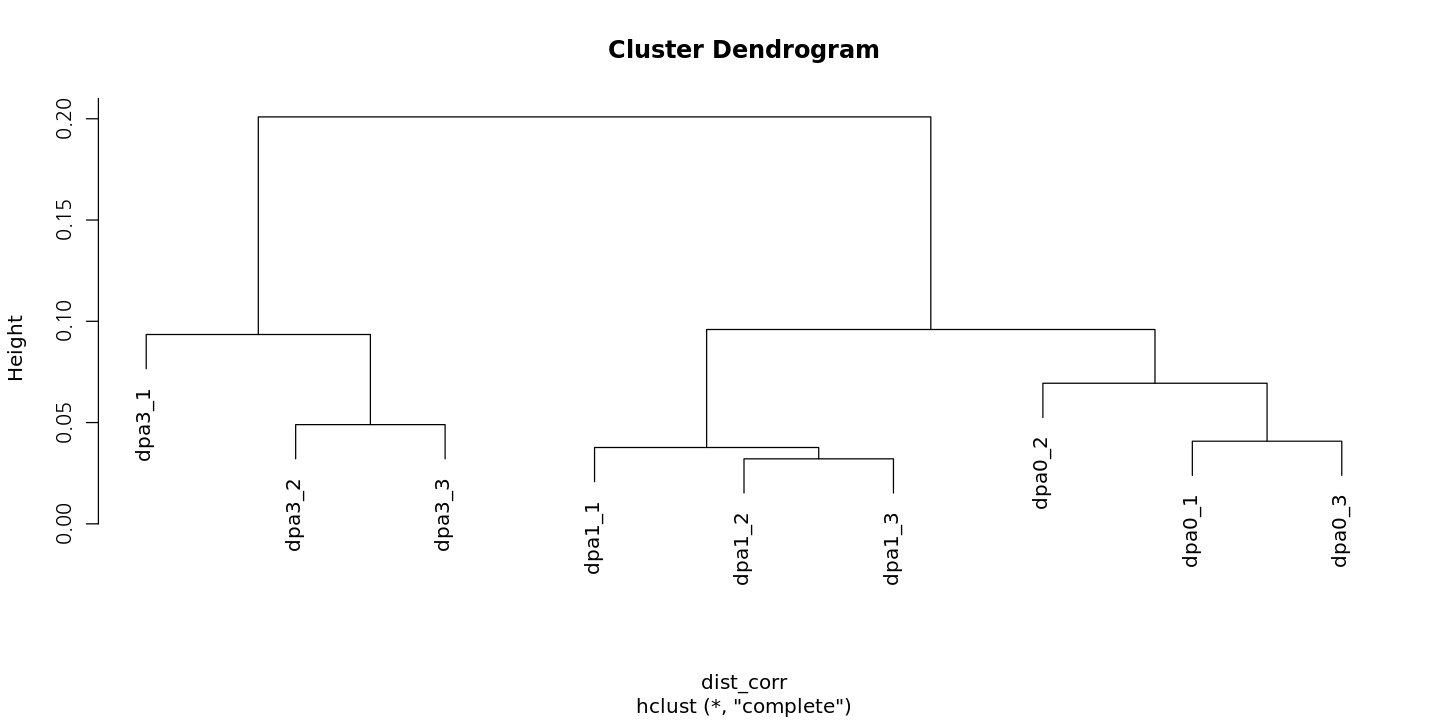

In [26]:
# Boxplot and hierarchical clustering with raw data
options(repr.plot.width=12, repr.plot.height=6)

boxplot(log(txi$abundance+0.001, base=2), las=2)
dist_corr <- dist(1-cor(as.matrix(txi$abundance), method='spearman'))
plot(hclust(dist_corr))

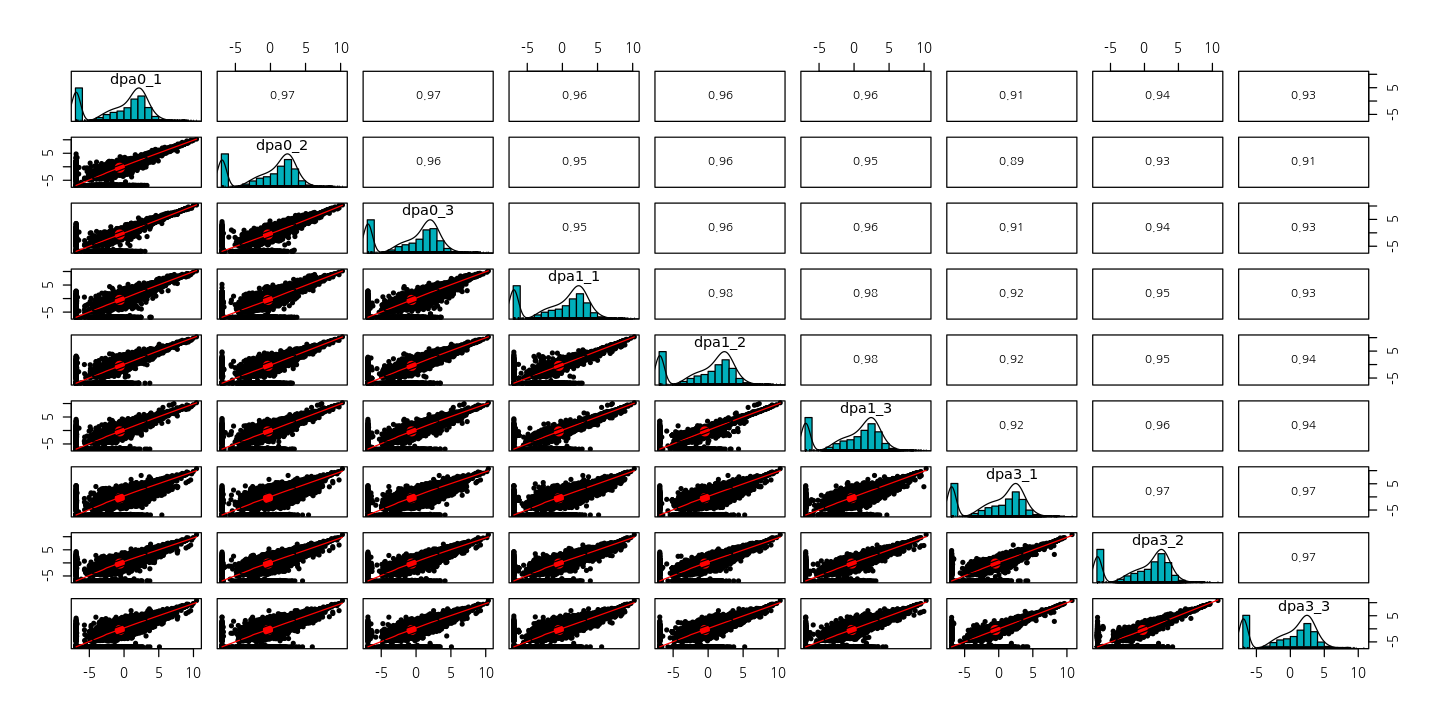

In [27]:
# Pair plot
library(psych)
pairs.panels(log(txi$abundance+0.001),
             method = "spearman", # correlation method
             hist.col = "#00AFBB",
             density = TRUE,  # show density plots
             ellipses = TRUE # show correlation ellipses
             )

In [28]:
groups <- gsub('_\\d+$','',samples$GroupName)
groups
batches <- gsub('^\\w+_','',samples$SampleName)
batches

# Creating a DGEList object for use in edgeR.
y <- DGEList(counts=txi$counts, group=groups)
y <- calcNormFactors(y)

design <- model.matrix(~0+groups)
colnames(design) <- gsub('groups', '', colnames(design))
design

[1] "dpa0" "dpa0" "dpa0" "dpa1" "dpa1" "dpa1" "dpa3" "dpa3" "dpa3"

[1] "1" "2" "3" "1" "2" "3" "1" "2" "3"

,dpa0,dpa1,dpa3
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,0,0,1
9,0,0,1


[1] 27177     9

[1] 18321     9

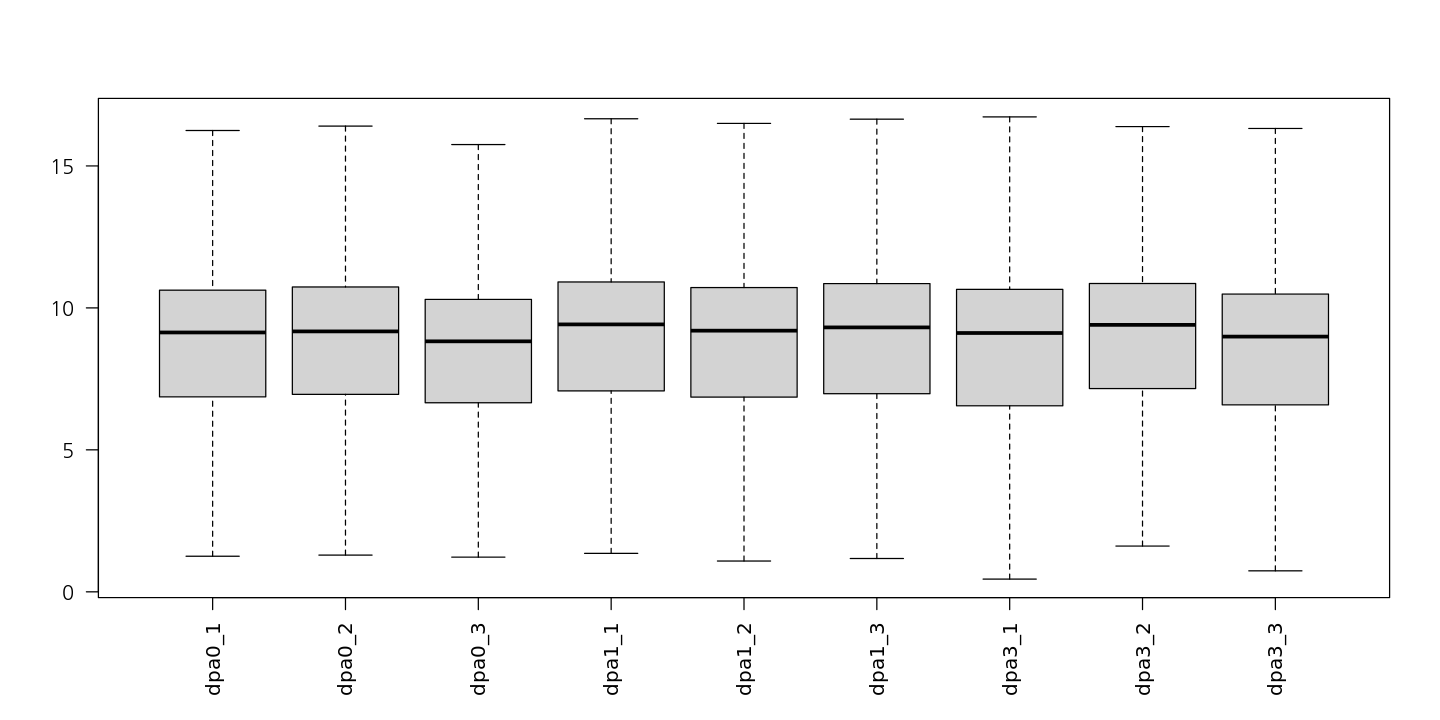

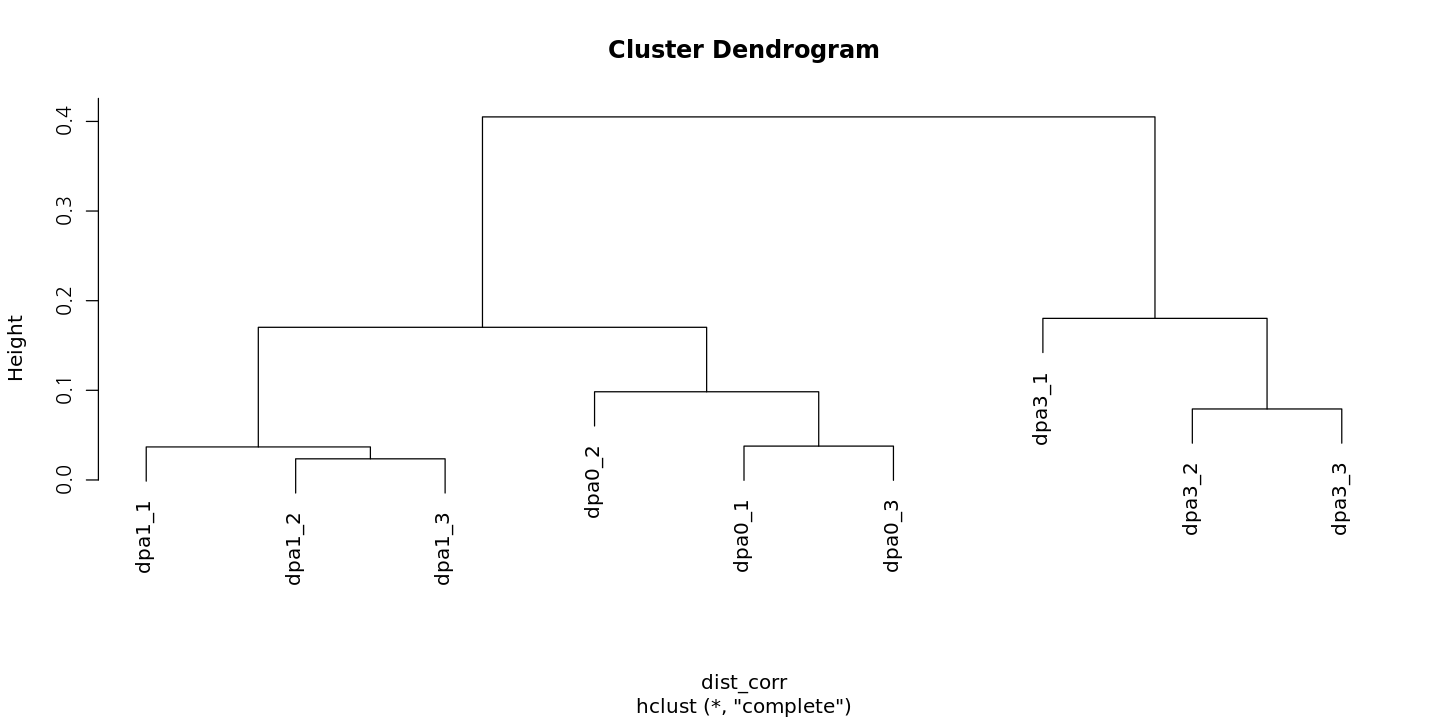

In [29]:
dim(y)
keep <- filterByExpr(y, group=groups)
y <- y[keep, , keep.lib.sizes=FALSE]
dim(y)

# Boxplot and hierarchical clustering with filtered data
options(repr.plot.width=12, repr.plot.height=6)

boxplot(log(as.matrix(y)+0.001, base=2), las=2, outline=FALSE)
dist_corr <- dist(1-cor(as.matrix(y), method='spearman'))
plot(hclust(dist_corr))

In [31]:
v <- voom(y, design)
fit_lm <- lmFit(v, design)
contrast_mat <- makeContrasts(dpa1-dpa0, dpa3-dpa0, dpa3-dpa1, levels=design)

fit_c <- contrasts.fit(fit_lm, contrast_mat)
fit_c <- eBayes(fit_c)

In [32]:
list_dpa1_dpa0 <- topTable(fit_c, coef=1, confint=TRUE, n=Inf, adjust="BH")
list_dpa3_dpa0 <- topTable(fit_c, coef=2, confint=TRUE, n=Inf, adjust="BH")
list_dpa3_dpa1 <- topTable(fit_c, coef=3, confint=TRUE, n=Inf, adjust="BH")

head(list_dpa1_dpa0)
head(list_dpa3_dpa0)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
il5ra,3.651210,3.359734,3.942687,4.967353,28.37349,4.676636e-10,8.568064e-06,13.05826
socs3l,3.060253,2.793157,3.327350,5.583484,25.95188,1.027911e-09,9.416175e-06,12.77221
wdr43,1.828802,1.631812,2.025792,5.930001,21.02817,6.537338e-09,2.418707e-05,11.24601
prps1,1.576608,1.396882,1.756334,6.875181,19.86977,1.073635e-08,2.418707e-05,10.77963
polr1a,2.592821,2.302098,2.883544,4.963593,20.20101,9.290514e-09,2.418707e-05,10.77501
pwp1,2.118751,1.868839,2.368662,5.281950,19.20319,1.446678e-08,2.418707e-05,10.46883


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
abi3bp,-2.714843,-2.928323,-2.501363,6.199325,-28.80492,4.092733e-10,7.498295e-06,13.71765
hsp90b1,2.484660,2.209511,2.759810,8.566945,20.45398,8.331616e-09,1.931090e-05,10.99355
lrp2bp,2.064739,1.833293,2.296185,5.502940,20.20667,9.267766e-09,1.931090e-05,10.90939
hba4,-4.830789,-5.370564,-4.291014,9.167257,-20.27144,9.011768e-09,1.931090e-05,10.88493
entpd1,2.054506,1.821164,2.287847,6.862029,19.94319,1.039554e-08,1.931090e-05,10.81883
MGC145260,2.610792,2.308998,2.912587,5.205660,19.59480,1.212749e-08,1.931090e-05,10.61396


In [35]:
#total_list <- list_dpa1_dpa0
#filename_out <- 'Pelzer2021_dpa1_dpa0'

#total_list <- list_dpa3_dpa0
#filename_out <- 'Pelzer2021_dpa3_dpa0'

total_list <- list_dpa3_dpa1
filename_out <- 'Pelzer2021_dpa3_dpa1'

DE_keep <- total_list$adj.P.Val <= 0.05 & abs(total_list$logFC) >= 1
DE_list <- total_list[DE_keep,]

filename_all <- paste(filename_out, 'limma_all.txt', sep='.')
write.table(total_list, filename_all, sep='\t')

filename_DE <- paste(filename_out, 'limma_DE.txt', sep='.')
write.table(DE_list, filename_DE, sep='\t')

#logCPM <- cpm(tbl_count, log=TRUE)
filename_cpm <- paste(filename_out, 'abundance.txt', sep='.')
write.table(txi$abundance, filename_cpm, sep='\t')